TODO
- df4 하기 > 추가 데이터를 이용한 파생 변수
- df5 정규화 방식 검토
- df6 feature selection 진행

# 전처리 가설 검증
- df_train + weather/oil 제외 추가데이터
- 모든 나라에 대해서 진행

# Setting

### Library

In [1]:
# Import Libraries
import os
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Visuzliation Setting
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import rc
from matplotlib import colors
import seaborn as sns

color_palette = 'Set3'
title_size = 20
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'NanumGothic'

# Modeling
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats

### Date

In [2]:
from datetime import date, timedelta


def set_week(df, date):
    '''
    df : datetime 형식의 컬럼을 가지고 있는 dataframe
    date : df에서 datetime 형식을 가진 컬럼명
    return : date의 연도 컬럼과 주차 컬럼을 추가한 dataframe
    '''
    df[date] = pd.to_datetime(df[date])
    df[date] = df[date].dt.date
    df['year'] = df.apply(func=lambda x: x[date].isocalendar()[0], axis=1)
    df['week'] = df.apply(func=lambda x: x[date].isocalendar()[1], axis=1)
    df.drop(date, axis=1, inplace=True)
    

def check_week(df):
    '''
    df에 date가 전부 있는지 확인
    '''
    cnt = 0
    sdate = date(2015, 12, 28)   # start date
    edate = date(2019, 12, 30)   # end date
    delta = edate - sdate       # as timedelta
    mem = set()
    
    for i in range(delta.days + 1):
        day = sdate + timedelta(days=i)
        year, week = day.isocalendar()[0], day.isocalendar()[1]
        if year * 100 + week in mem:
            continue
        mem.add(year * 100 + week)
        if df[(df['year'] == year) & (df['week'] == week)].empty:
            print((year, week), end="")
            cnt += 1
    if cnt > 0:
        print()
    print("missing", cnt, "values")    

### Model

In [3]:
def RMSE(y, y_pred):
    return mean_squared_error(y, y_pred)**0.5


def train_model(train_data, target_data, model=LinearRegression()):  # baseline model : LInearRegression
    x_train, x_test, y_train, y_test = train_test_split(train_data, target_data, random_state=0)

    model.fit(x_train, y_train)
    print("Model Training Complete!")

    pred_train, pred_test = model.predict(x_train), model.predict(x_test)
    
    plt.figure(figsize=(10, 8))
#     plt.scatter(pred_train, y_train, s=10)
    sns.regplot(pred_train, y_train, color='g')
    plt.xlabel("Predicted price")
    plt.ylabel("Actual price")
    plt.show()

    # cvs = cross_val_score(model, x_test, y_test, cv = 5)
    # print(">> cross_val_score mean =", cvs.mean())
    print(">> RMSE train =", RMSE(y_train, pred_train))
    print(">> RMSE validation =", RMSE(y_test, pred_test))
    print(">> MAE train =", mean_absolute_error(pred_train, y_train))
    print(">> MAE validation =", mean_absolute_error(pred_test, y_test))
    print("-------------------------------------------------")
    
    return model

    
def print_importance(model, df, added_columns):
    importance = model.coef_
    fs_data = []
    for i, x in enumerate(importance):
        fs_data.append([abs(x), df.columns[i]])
    fs_data.sort(key=lambda x: x[0], reverse=True)
   
    # 추가한 컬럼의 중요도
    for i in range(len(fs_data)):
        if fs_data[i][1] in added_columns:
            print(fs_data[i][1], ":", fs_data[i][0] ,">", i, "순위")
    print("-------------------------------------------------")
    print("총", len(fs_data) , "개")
    
    return fs_data

### Data directory

In [4]:
root = os.path.join(os.getcwd(), 'DATA')

### Merging dataframes

In [5]:
from functools import reduce

def merge_df(df_list):
    return reduce(lambda  left,right: pd.merge(left,right, on=['year', 'week'], how='left'), df_list)

# Import Data

In [6]:
df_train = pd.read_excel(os.path.join(root, 'train.xlsx'))
df_oil = pd.read_csv(os.path.join(root, 'preprocessed_oil.csv'))
df_weather_kr = pd.read_csv(os.path.join(root, 'preprocessed_weather_korea.csv'))
df_cpi = pd.read_csv(os.path.join(root, 'preprocessed_cpi.csv'))

----

# Baseline Dataframe
**df_train**:  
- 'REG_DATE' to 'year', 'week'
- One hot encoding on categorical features

## Preprocess

In [7]:
df0_base = df_train.copy()

### Add Columns

In [8]:
df0_base = df0_base.replace([np.datetime64('2017-01-01'), np.datetime64('2017-01-06')],
                            [np.datetime64('2017-01-02'), np.datetime64('2017-01-09')])

In [9]:
set_week(df0_base, 'REG_DATE')

In [10]:
check_week(df0_base)

missing 0 values


### One hot encoding

In [11]:
# P_IMPORT_TYPE
import_type_list = set()
for tmp in df0_base.P_IMPORT_TYPE.unique():
    for a in tmp.split(','):
        import_type_list.add(a)
for name in import_type_list:
    df0_base[name] = 0
    df0_base.loc[df0_base['P_IMPORT_TYPE'].str.contains(name, regex=False), name] = 1

In [12]:
# Others
one_hot = ['CTRY_1', 'CTRY_2', 'P_PURPOSE', 'CATEGORY_1', 'CATEGORY_2', 'P_NAME']
df0_base = pd.get_dummies(df0_base, columns=one_hot)

### Drop Columns

In [13]:
drop = ['P_TYPE', 'P_IMPORT_TYPE']
df0_base.drop(columns = drop, inplace=True)

## Train

#### Numerical Features

In [14]:
numerical_columns = ['P_PRICE', 'year', 'week']

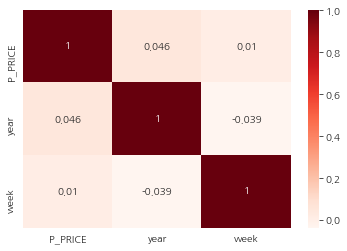

In [15]:
#Using Pearson Correlation
plt.figure(figsize=(6, 4))
cor = df0_base[numerical_columns].corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

날짜 데이터('year', 'week')는 P_PRICE 결정에 큰 영향을 미치지 않음을 확인 할 수 있다  
다만, 데이터를 추가하는 기준으로 사용해야하므로 인덱스로 가져가준다

Model Training Complete!


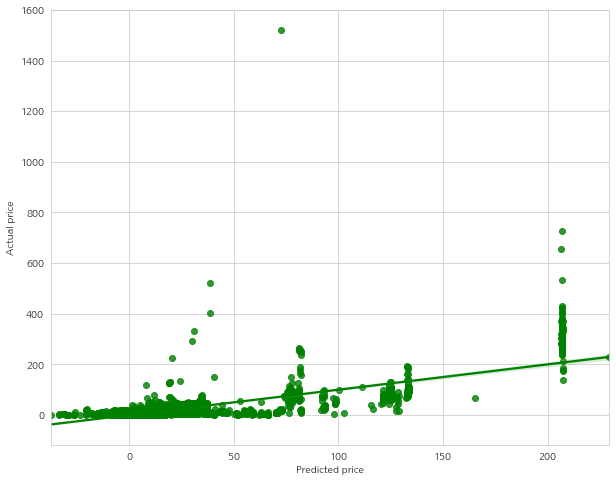

>> RMSE train = 14.252151221871804
>> RMSE validation = 780583463.4716753
>> MAE train = 4.1786475288616
>> MAE validation = 24199727.278879352
-------------------------------------------------


In [16]:
model0 = train_model(df0_base.drop(columns=['P_PRICE']), df0_base['P_PRICE'])

In [17]:
# plot feature importance
features = print_importance(model0, df0_base, [])

-------------------------------------------------
총 625 개


In [18]:
# tmp_df = pd.DataFrame(columns=['Column', '종류', '값'])

In [19]:
# for i in range(len(features)):
#     if features[i][1].startswith('P_NAME'):
#         name = features[i][1].strip('P_NAME_')
# #         tmp_df = tmp_df.append({'Column': name, '종류': 'importance', '값': i}, ignore_index=True)
#         tmp_df = tmp_df.append({'Column': name, '종류': 'count', '값': df0_base[features[i][1]].sum()}, ignore_index=True)

In [20]:
# plt.figure(figsize=(12, 35))
# g = sns.barplot(x='값', y='Column', data=tmp_df)
# g.set(xlim=(0, 1700))
# plt.title("P_NAME 각 수 및 우선순위",fontsize=title_size)
# plt.show()

----

# Adding Columns
- 어종별 수 컬럼 추가
- 수입용도 수 컬럼 추가
- 가공여부 컬럼 추가

In [170]:
df1_add_columns = df_train.copy()

## Preprocess

In [171]:
df1_add_columns = df1_add_columns.replace([np.datetime64('2017-01-01'), np.datetime64('2017-01-06')],
                                          [np.datetime64('2017-01-02'), np.datetime64('2017-01-09')])

In [172]:
set_week(df1_add_columns, 'REG_DATE')  # 날짜 추가

#### Add columns

In [173]:
added_columns = []

In [174]:
def get_cnt(df, column, new_column):
    value_dict = {}
    for name, value in zip(df[column].value_counts().index, df[column].value_counts()):
        value_dict[name] = value
    def value(col):
        return value_dict[col]

    df[new_column] = df[column].apply(value)

In [175]:
# 제조국 수 컬럼 추가
get_cnt(df1_add_columns, 'CTRY_1', 'ctry1_cnt')
added_columns.append('ctry1_cnt')

In [176]:
# 수출국 수 컬럼 추가
get_cnt(df1_add_columns, 'CTRY_2', 'ctry2_cnt')
added_columns.append('ctry2_cnt')

In [177]:
# 수입용도 수 컬럼 추가
get_cnt(df1_add_columns, 'P_PURPOSE', 'purpose_cnt')
added_columns.append('purpose_cnt')

In [178]:
#  
get_cnt(df1_add_columns, 'CATEGORY_1', 'category1_cnt')
added_columns.append('category1_cnt')

In [179]:
#  
get_cnt(df1_add_columns, 'CATEGORY_2', 'category2_cnt')
added_columns.append('category2_cnt')

In [180]:
# 어종별 수 컬럼 추가
get_cnt(df1_add_columns, 'P_NAME', 'name_cnt')
added_columns.append('name_cnt')

In [181]:
# 가공 여부 컬럼 추가
df1_add_columns['is_processed'] = (df1_add_columns['CTRY_1'] != df1_add_columns['CTRY_2'])
added_columns.append('is_processed')

In [182]:
# 수입형태
import_type_list = set()
for tmp in df1_add_columns.P_IMPORT_TYPE.unique():
    for a in tmp.split(','):
        import_type_list.add(a)
for name in import_type_list:
    df1_add_columns[name] = 0
    df1_add_columns.loc[df1_add_columns['P_IMPORT_TYPE'].str.contains(name, regex=False), name] = 1

In [183]:
# 수입형태 수 컬럼 추가
df1_add_columns['import_cnt'] = 0
for i, row in df1_add_columns.iterrows():
    for name in import_type_list:
        if row[name] == 1:
            df1_add_columns.at[i, 'import_cnt'] += 1
added_columns.append('import_cnt')

In [184]:
# 분기 추가


#### One hot encoding

In [37]:
# Others
one_hot = ['CTRY_1', 'CTRY_2', 'P_PURPOSE', 'CATEGORY_1', 'CATEGORY_2', 'P_NAME']
df1_add_columns = pd.get_dummies(df1_add_columns, columns=one_hot)

### Drop Columns

In [38]:
drop = ['P_TYPE', 'P_IMPORT_TYPE']
df1_add_columns.drop(columns = drop, inplace=True)

## Check

In [39]:
df1_add_columns['name_cnt'].describe()

count    42073.000000
mean       803.035129
std        739.916364
min          1.000000
25%        208.000000
50%        512.000000
75%       1298.000000
max       2601.000000
Name: name_cnt, dtype: float64

In [40]:
df1_add_columns['import_cnt'].value_counts()

1    28079
2     7194
3     4780
4     1518
5      502
Name: import_cnt, dtype: int64

In [41]:
df1_add_columns['is_processed'].value_counts()

False    37634
True      4439
Name: is_processed, dtype: int64

## Train

Model Training Complete!


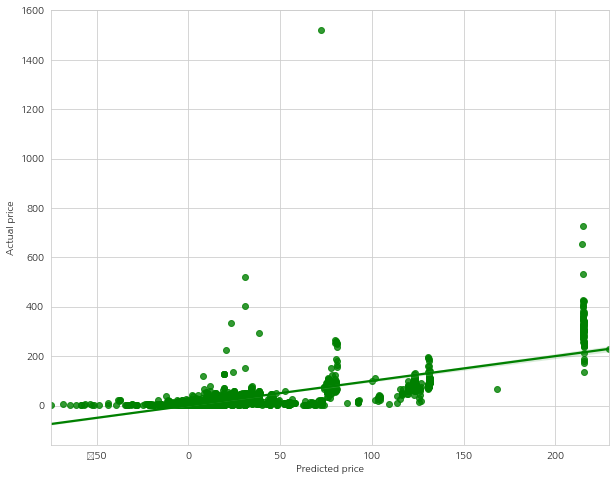

>> RMSE train = 14.09282714512467
>> RMSE validation = 10.295894978533711
>> MAE train = 4.047708877162302
>> MAE validation = 4.03755432406878
-------------------------------------------------


In [42]:
model1 = train_model(df1_add_columns.drop(columns=['P_PRICE']), df1_add_columns['P_PRICE'])

In [43]:
t = print_importance(model1, df1_add_columns, added_columns)

name_cnt : 28.946773964235504 > 52 순위
is_processed : 26.363154978199972 > 61 순위
import_cnt : 9.89191497283703 > 133 순위
category2_cnt : 0.0036399098791525253 > 616 순위
ctry1_cnt : 0.0025455376433234037 > 618 순위
category1_cnt : 0.001675252261414295 > 619 순위
purpose_cnt : 0.0002467266318495198 > 620 순위
ctry2_cnt : 6.113680872195208e-05 > 621 순위
-------------------------------------------------
총 633 개


- name_cnt와 import_Cnt 는 중요도가 꽤나 높다
- 그 외는 작다
- 그럼에도 변수 추가를 통해 모델 정확도가 상승한 것을 확인할 수 있다

----

# Detecting Anomaly & Standardization

In [44]:
df2_transformed = df1_add_columns.copy()

## Univariate Analysis

In [45]:
price_scale = StandardScaler().fit_transform(df2_transformed['P_PRICE'][:,np.newaxis]);
low_range = price_scale[price_scale[:,0].argsort()][:10]
high_range= price_scale[price_scale[:,0].argsort()][-10:]
print('outer range (low) of the distribution:')
print(*low_range)
print('\nouter range (high) of the distribution:')
print(*high_range)

outer range (low) of the distribution:
[-0.42627644] [-0.42565957] [-0.42416684] [-0.42416684] [-0.42357363] [-0.42218509] [-0.42188523] [-0.42188523] [-0.42070824] [-0.42067252]

outer range (high) of the distribution:
[18.26347503] [18.78538898] [18.87682707] [19.12537739] [23.1868877] [23.34962944] [23.82255889] [29.42611827] [32.77259233] [69.01834283]


- lower range 는 0에 가까워 크게 신경 쓸 필요 없다
- higher range의 경우 상당히 큰 값들이 있음을 확인할 수 있다
- 이 중 특히 마지막 3 ~ 6개는 그 값이 급증하므로 이상치로 생각할 수 있다

## Bivariate Analysis

- name_cnt
- import_cnt

추가한 numerical feature 중 중요도가 높았던 두 변수에 대해 bivariate analysis를 진행한다

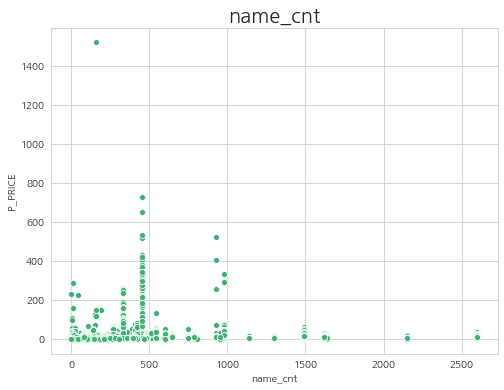

In [46]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='name_cnt', y='P_PRICE', data=df2_transformed, color='mediumseagreen')
plt.title("name_cnt",fontsize=title_size)
plt.show()

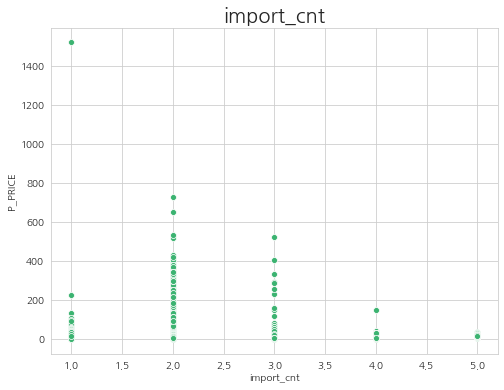

In [47]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='import_cnt', y='P_PRICE', data=df2_transformed, color='mediumseagreen')
plt.title("import_cnt",fontsize=title_size)
plt.show()

앞서 이상치가 6개가 될 것이라고 예상하였는데,  
역시나 공통적으로 P_PRICE가 약 500 이상인 값이 눈에 띄게 크다  
따라서 해당 row는 anamoly 로 취급한다

In [48]:
# Drop Row
df2_transformed = df2_transformed[df2_transformed['P_PRICE'] < 500]

## Standardization

Numerical feature 에 대해서 정규화를 진행해야한다
- P_PRICE
- ctry1_cnt
- ctry2_cnt
- purpose_cnt
- name_cnt
- category1_cnt
- category2_cnt
- import_cnt

이 중, target value 인 P_PRICE와 함께 앞서 확인한 우선순위가 높은 name_cnt, import_cnt에 대해 진행한다

#### P_PRICE

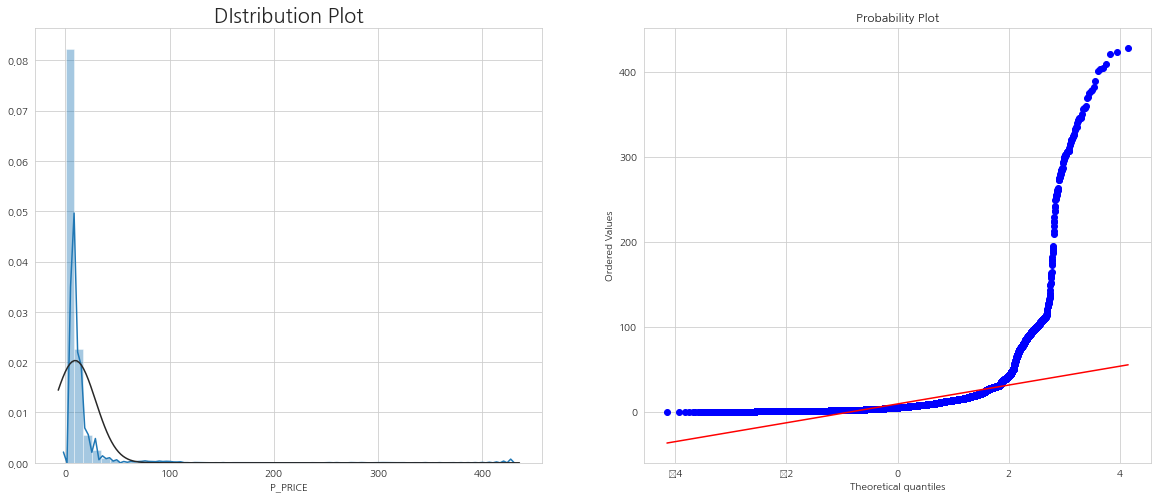

In [49]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df2_transformed['P_PRICE'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df2_transformed['P_PRICE'], plot=plt)

plt.show()

- Peakedness
- Positive Skewedness
- Doesn't follow the diagonal line

In [50]:
df2_transformed['P_PRICE'] = np.log1p(df2_transformed['P_PRICE'])

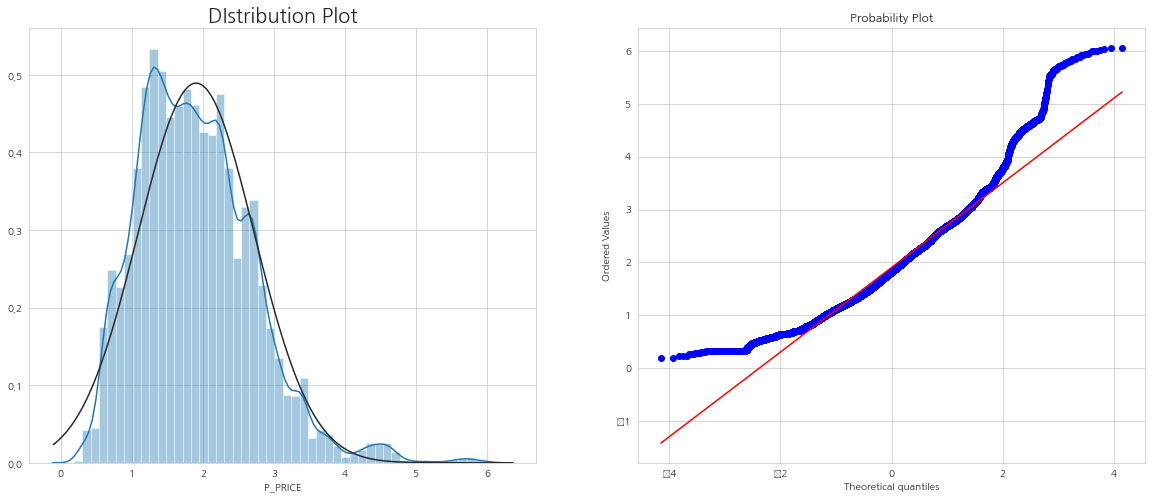

In [51]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df2_transformed['P_PRICE'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df2_transformed['P_PRICE'], plot=plt)

plt.show()

#### name_cnt

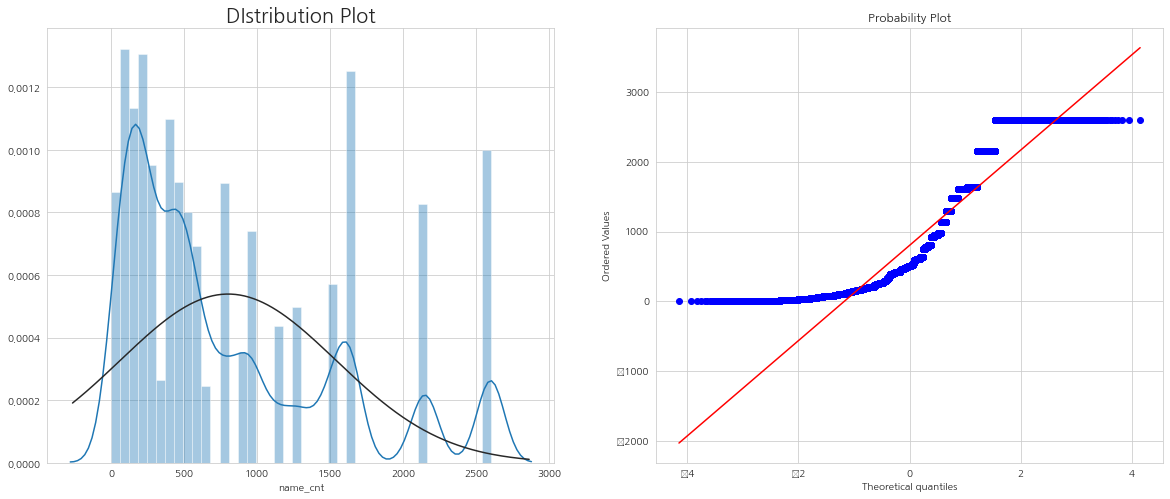

In [52]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df2_transformed['name_cnt'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df2_transformed['name_cnt'], plot=plt)

plt.show()

In [53]:
df2_transformed['name_cnt'] = np.log1p(df2_transformed['name_cnt'])

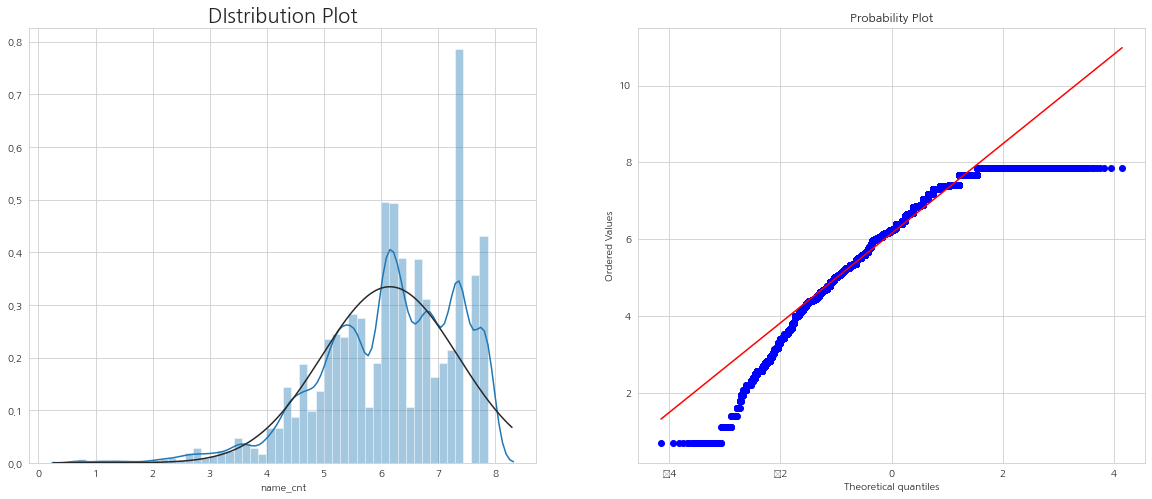

In [54]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df2_transformed['name_cnt'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df2_transformed['name_cnt'], plot=plt)

plt.show()

#### import_cnt

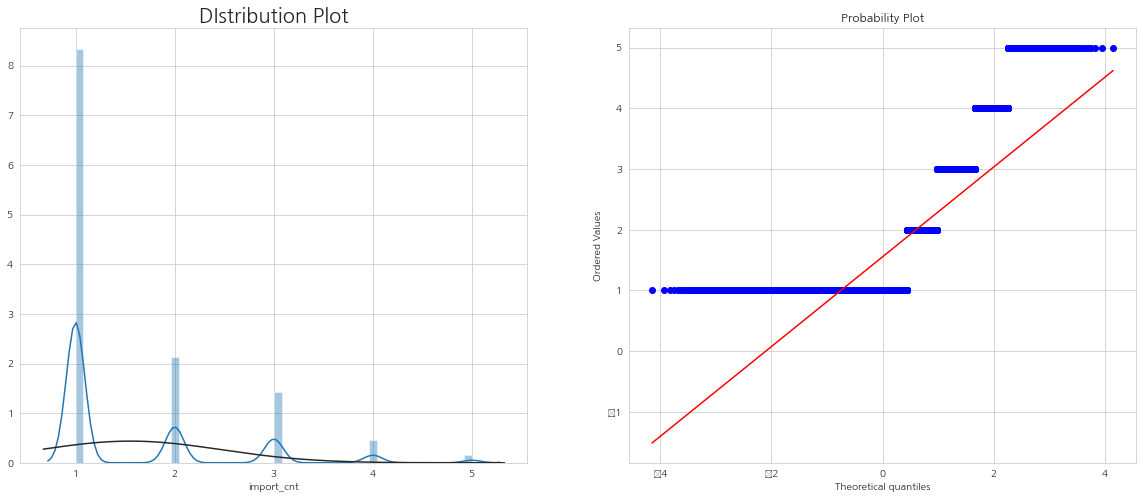

In [55]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df2_transformed['import_cnt'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df2_transformed['import_cnt'], plot=plt)

plt.show()

In [56]:
df2_transformed['import_cnt'] = np.log1p(df2_transformed['import_cnt'])

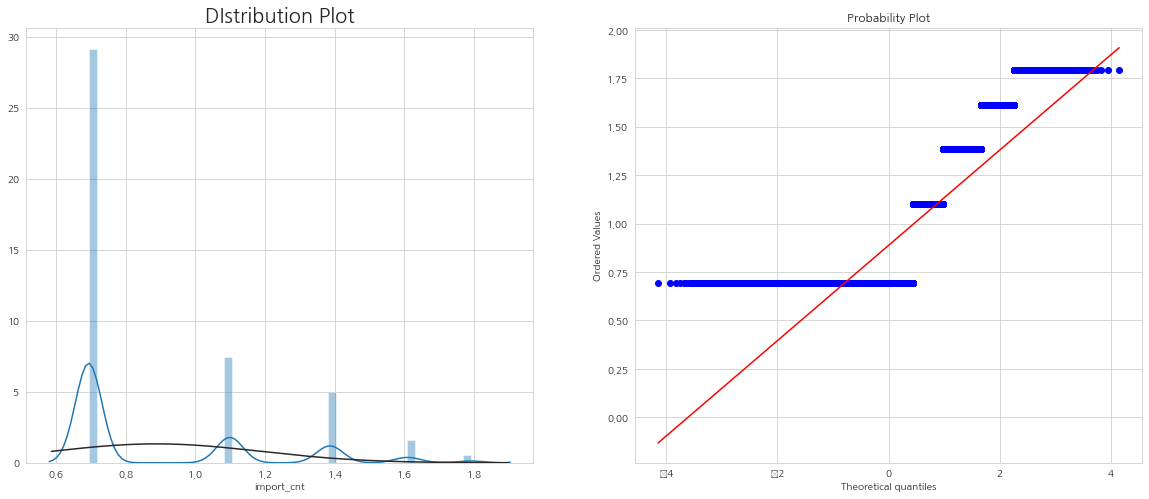

In [57]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df2_transformed['import_cnt'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df2_transformed['import_cnt'], plot=plt)

plt.show()

## Train

Model Training Complete!


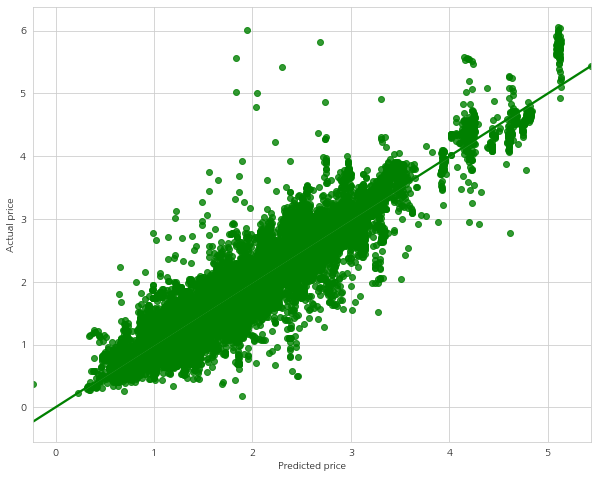

>> RMSE train = 0.2616368457199349
>> RMSE validation = 0.2718320385266649
>> MAE train = 0.17981378869176973
>> MAE validation = 0.18713514628850883
-------------------------------------------------


In [58]:
model2 = train_model(df2_transformed.drop(columns=['P_PRICE']), df2_transformed['P_PRICE'])

# Adding Data

In [59]:
df3_add_data = merge_df([df2_transformed, df_oil, df_weather_kr, df_cpi])

## Preprocess
추가한 데이터 모두 numerical feature 이므로 위와 같이 정규화를 해준다
- oil
- wind_kr
- temperature_kr
- water_temp_kr
- cpi_total
- cpi_fish

In [60]:
added_columns = ['oil', 'wind_kr', 'temperature_kr', 'water_temp_kr', 'cpi_total', 'cpi_fish']

#### oil

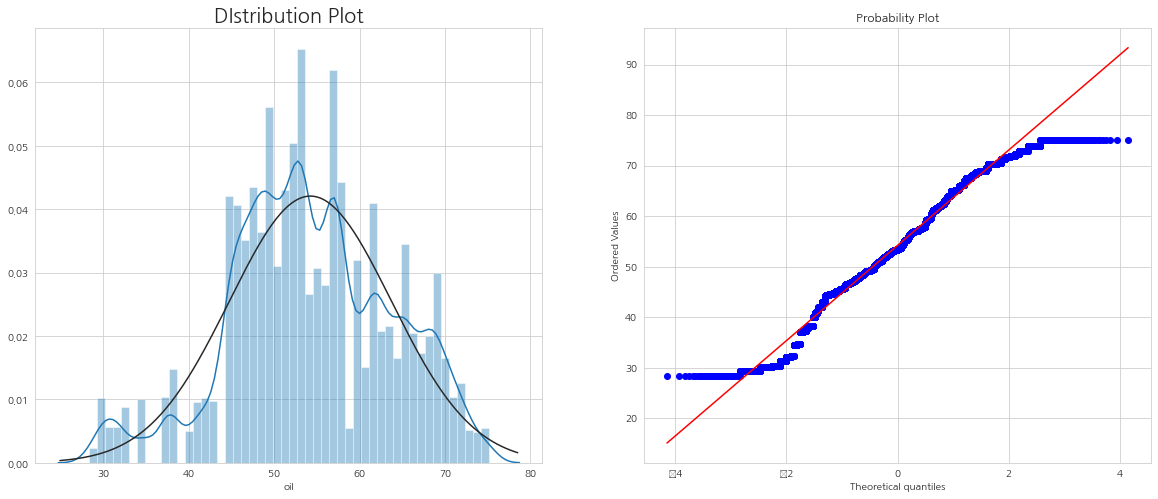

In [61]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df3_add_data['oil'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df3_add_data['oil'], plot=plt)

plt.show()

In [62]:
df3_add_data['oil'] = np.log1p(df3_add_data['oil'])

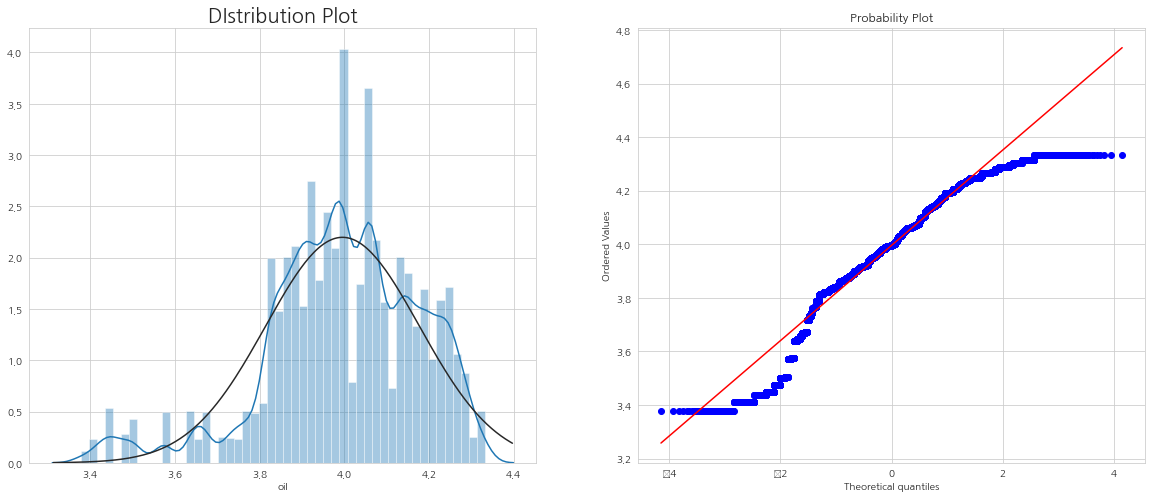

In [63]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df3_add_data['oil'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df3_add_data['oil'], plot=plt)

plt.show()

#### wind_kr

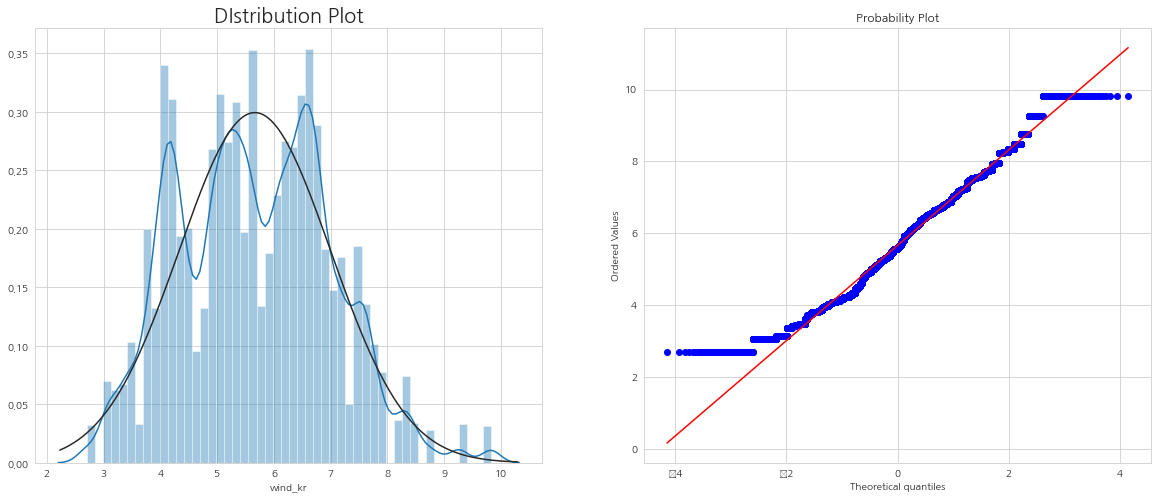

In [64]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df3_add_data['wind_kr'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df3_add_data['wind_kr'], plot=plt)

plt.show()

In [65]:
df3_add_data['wind_kr'] = np.log1p(df3_add_data['wind_kr'])

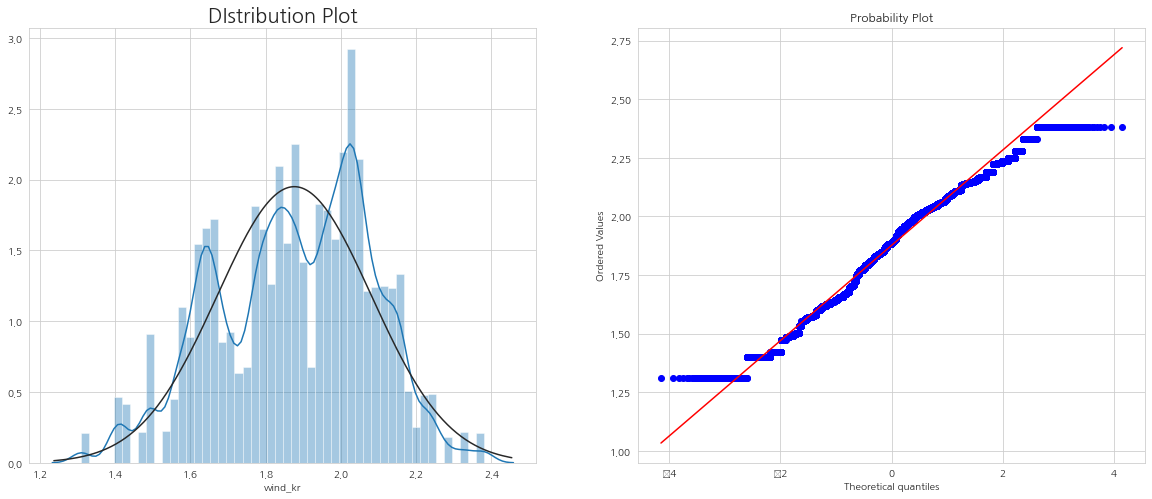

In [66]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df3_add_data['wind_kr'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df3_add_data['wind_kr'], plot=plt)

plt.show()

#### temperature_kr

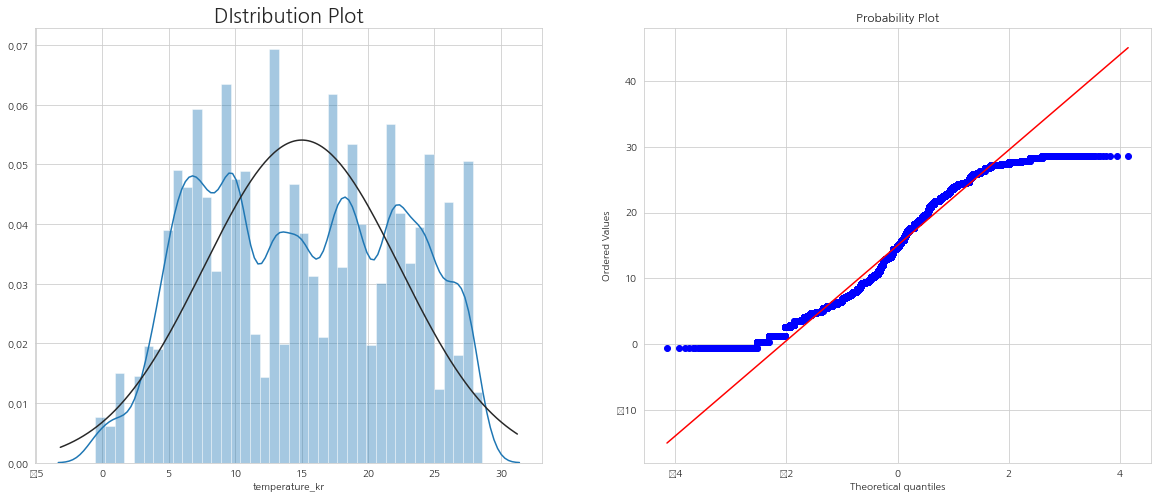

In [67]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df3_add_data['temperature_kr'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df3_add_data['temperature_kr'], plot=plt)

plt.show()

In [68]:
df3_add_data['temperature_kr'] = np.log1p(df3_add_data['temperature_kr'])

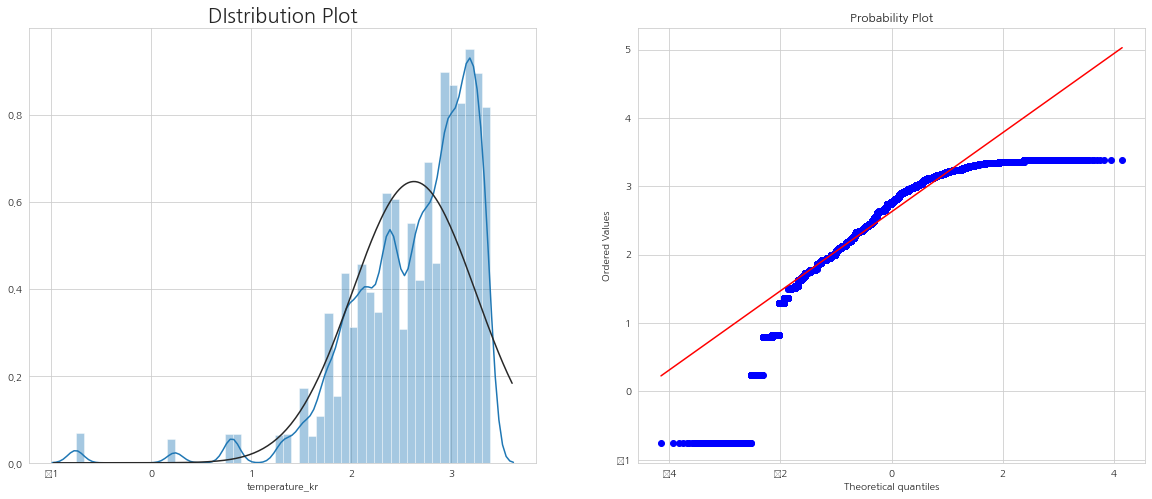

In [69]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df3_add_data['temperature_kr'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df3_add_data['temperature_kr'], plot=plt)

plt.show()

#### water_temp_kr

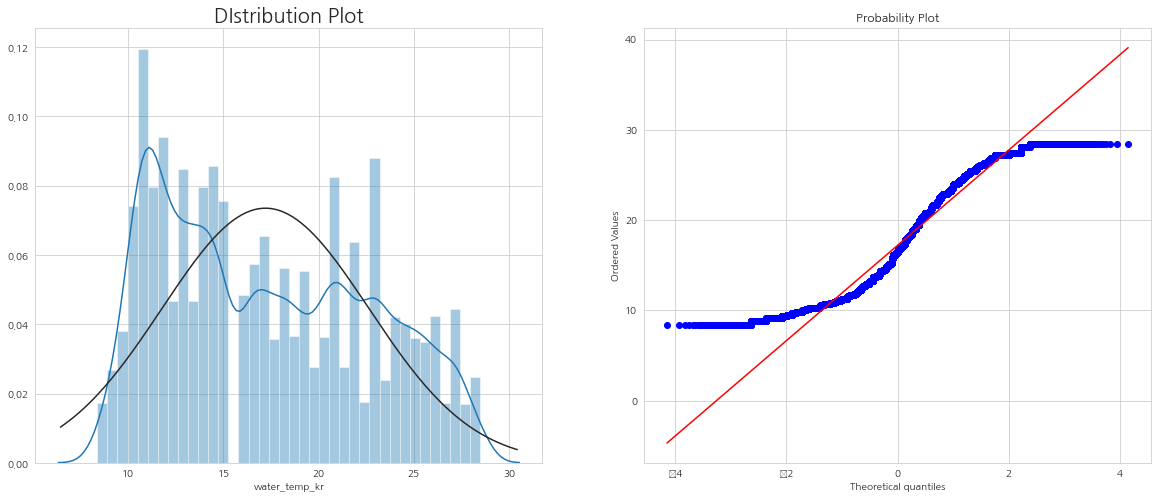

In [70]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df3_add_data['water_temp_kr'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df3_add_data['water_temp_kr'], plot=plt)

plt.show()

In [71]:
df3_add_data['water_temp_kr'] = np.log1p(df3_add_data['water_temp_kr'])

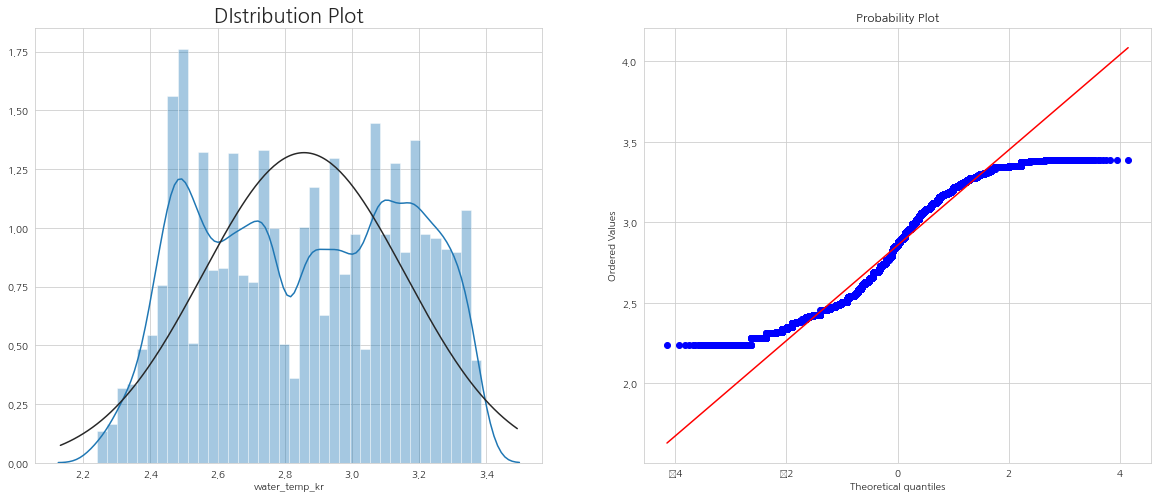

In [72]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df3_add_data['water_temp_kr'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df3_add_data['water_temp_kr'], plot=plt)

plt.show()

#### cpi_total

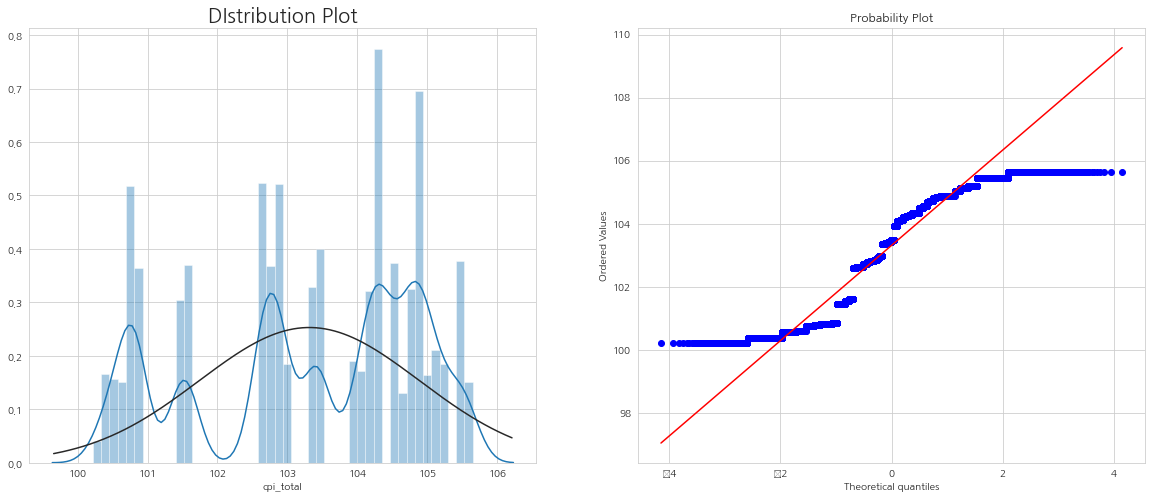

In [73]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df3_add_data['cpi_total'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df3_add_data['cpi_total'], plot=plt)

plt.show()

In [74]:
df3_add_data['cpi_total'] = np.log1p(df3_add_data['cpi_total'])

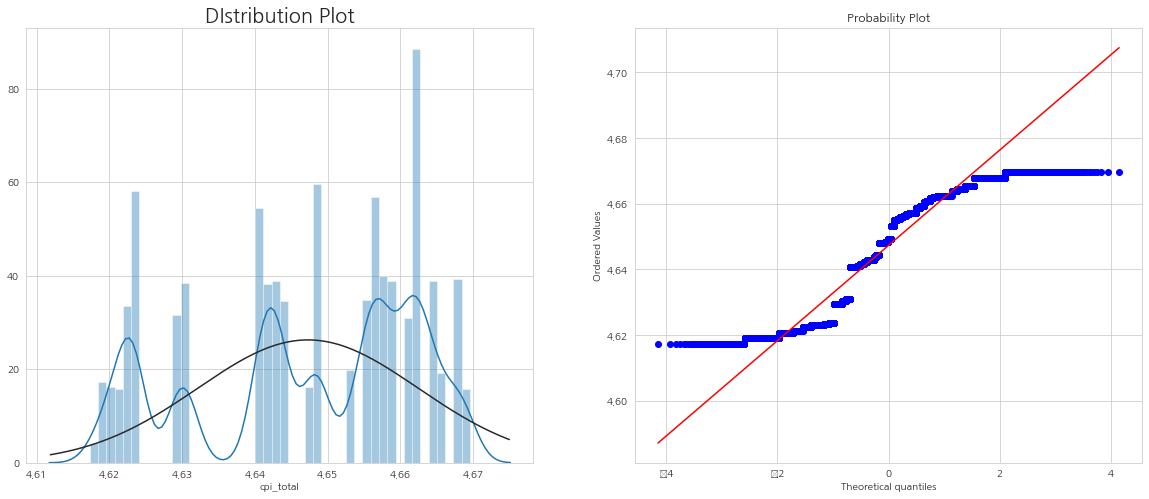

In [75]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df3_add_data['cpi_total'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df3_add_data['cpi_total'], plot=plt)

plt.show()

#### cpi_fish

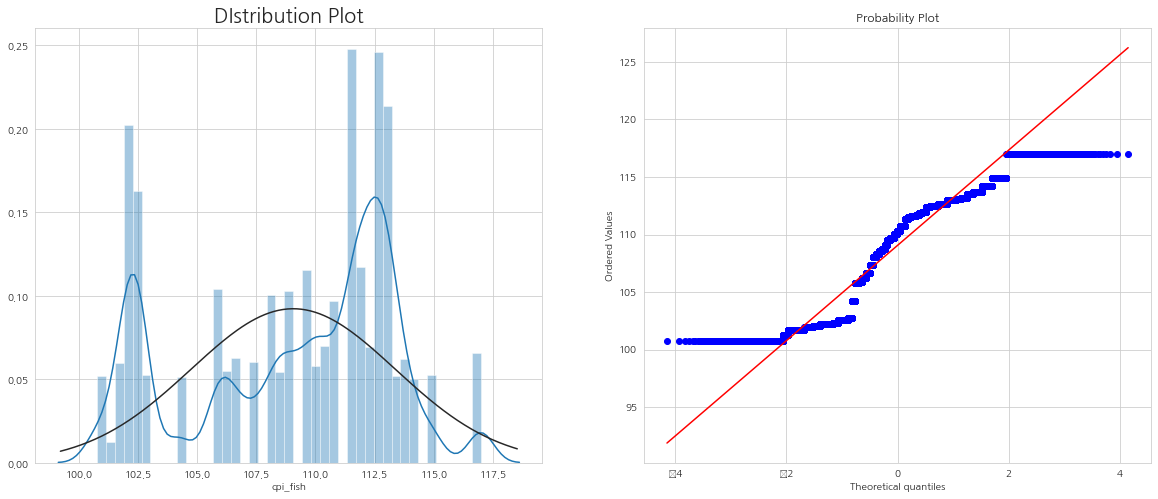

In [76]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df3_add_data['cpi_fish'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df3_add_data['cpi_fish'], plot=plt)

plt.show()

In [77]:
df3_add_data['cpi_fish'] = np.log1p(df3_add_data['cpi_fish'])

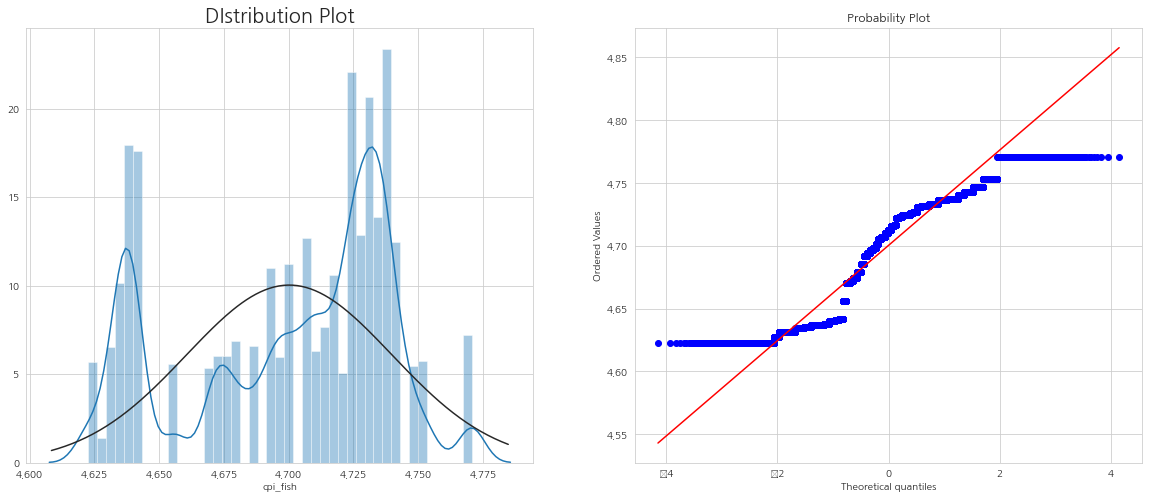

In [78]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('DIstribution Plot', fontsize=title_size)
sns.distplot(df3_add_data['cpi_fish'], fit=norm);

plt.subplot(1, 2, 2)
plt.title('Probability Plot', fontsize=title_size)
stats.probplot(df3_add_data['cpi_fish'], plot=plt)

plt.show()

## Train

Model Training Complete!


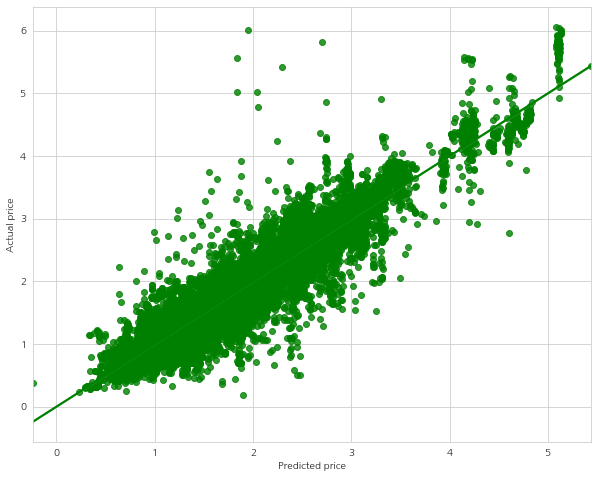

>> RMSE train = 0.26122564903026557
>> RMSE validation = 0.2713887439942021
>> MAE train = 0.17936267453830623
>> MAE validation = 0.1867448876924618
-------------------------------------------------


In [79]:
model3 = train_model(df3_add_data.drop(columns=['P_PRICE']), df3_add_data['P_PRICE'])

In [80]:
t = print_importance(model3, df3_add_data, added_columns)

water_temp_kr : 1.4879267935825102 > 6 순위
cpi_total : 0.21405527006366554 > 325 순위
temperature_kr : 0.01917148754625786 > 582 순위
oil : 0.003749417744357088 > 612 순위
wind_kr : 0.0035254717515779133 > 614 순위
-------------------------------------------------
총 639 개


- 순위가 별로 높지 않으며, 모델 성능이 크게 개선되지 않음을 발견할 수 있다
- 다만, 몇 없는 numerical feature 이므로 파생 변수를 추가하는 방향으로 고려해볼 수 있을 것이다

----

# Adding Columns (Based on Additional Data)

In [81]:
df4_add_columns = df3_add_data.copy()

In [168]:
df4_add_columns.columns

Index(['P_PRICE', 'year', 'week', 'ctry1_cnt', 'ctry2_cnt', 'purpose_cnt',
       'category1_cnt', 'category2_cnt', 'name_cnt', 'is_processed',
       ...
       'P_NAME_흑점샛돔알', 'P_NAME_흑점줄전갱이', 'P_NAME_흰꼴뚜기', 'P_NAME_흰다리새우', 'oil',
       'wind_kr', 'temperature_kr', 'water_temp_kr', 'cpi_total', 'cpi_fish'],
      dtype='object', length=640)

----

# Grouping

In [129]:
df5_feature_selection = df_train.copy()

## Preprocess

In [130]:
# 컬럼 삭제
df5_feature_selection = df5_feature_selection.drop(columns=['P_TYPE'])

In [131]:
# 날씨
df5_feature_selection = df5_feature_selection.replace([np.datetime64('2017-01-01'), np.datetime64('2017-01-06')],
                                                      [np.datetime64('2017-01-02'), np.datetime64('2017-01-09')])

set_week(df5_feature_selection, 'REG_DATE')

In [132]:
# 파생변수 추가
get_cnt(df5_feature_selection, 'CTRY_1', 'ctry1_cnt')  # 제조국 수 컬럼 추가
get_cnt(df5_feature_selection, 'CTRY_2', 'ctry2_cnt')  # 수출국 수 컬럼 추가
get_cnt(df5_feature_selection, 'P_PURPOSE', 'purpose_cnt')  # 수입용도 수 컬럼 추가
get_cnt(df5_feature_selection, 'CATEGORY_1', 'category1_cnt')
get_cnt(df5_feature_selection, 'CATEGORY_2', 'category2_cnt')
get_cnt(df5_feature_selection, 'P_NAME', 'name_cnt')  # 어종별 수 컬럼 추가
df5_feature_selection['is_processed'] = (df5_feature_selection['CTRY_1'] != df5_feature_selection['CTRY_2'])  # 가공 여부 컬럼 추가

In [133]:
# 파생변수 추가
import_type_list = set()
for tmp in df5_feature_selection.P_IMPORT_TYPE.unique():
    for a in tmp.split(','):
        import_type_list.add(a)
        
df5_feature_selection['import_cnt'] = 0
for name in import_type_list:
    df5_feature_selection.loc[df5_feature_selection['P_IMPORT_TYPE'].str.contains(name, regex=False), 'import_cnt'] += 1

In [ ]:
# # P_IMPORT_TYPE 카테고리화
# new_df = pd.DataFrame(columns=df5_feature_selection.columns)
# for i, row in df5_feature_selection.iterrows():
#     import_type = df5_feature_selection.iloc[i]['P_IMPORT_TYPE']
#     for name in import_type_list:
#         if name in import_type:
#             data = df5_feature_selection.iloc[i]
#             data['P_IMPORT_TYPE'] = name
#             new_df = new_df.append(data)

In [135]:
# 이상치 제거
df5_feature_selection = df5_feature_selection[df5_feature_selection['P_PRICE'] < 500]

In [136]:
# 데이터 추가
df5_feature_selection = merge_df([df5_feature_selection, df_oil, df_weather_kr, df_cpi])

In [137]:
# 정규화
df5_feature_selection['P_PRICE'] = np.log1p(df5_feature_selection['P_PRICE'])
# added = added_columns + ['name_cnt', 'import_cnt']
# for column in added:
#     df5_feature_selection[column] = np.log1p(df5_feature_selection[column])

## Grouping by Correlation
- P_PRICE 와 상관관계가 높은 변수 찾기
- 서로 상관관계가 높은 변수 찾기

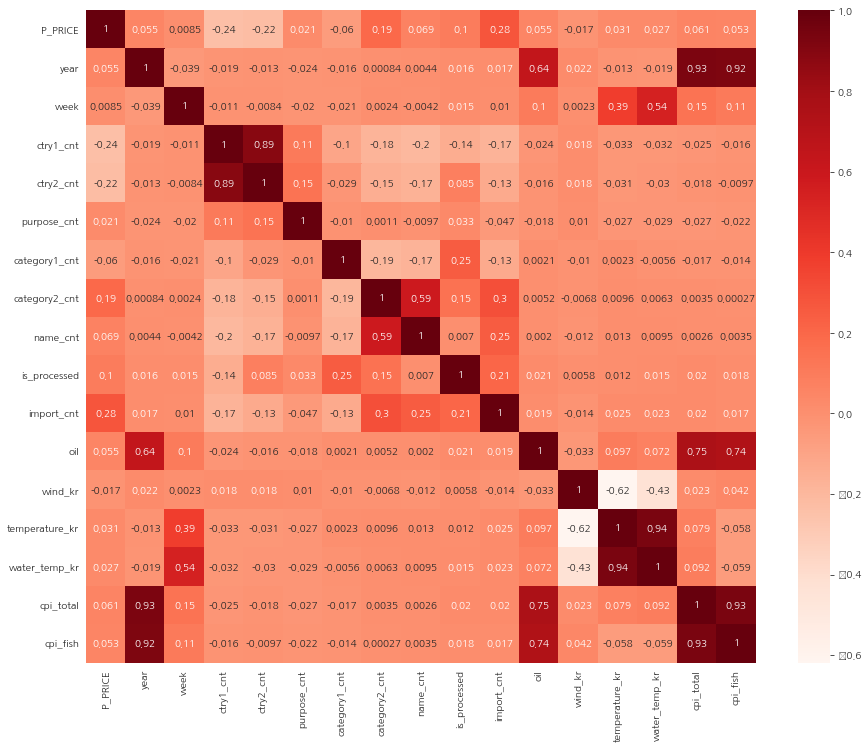

In [138]:
#Using Pearson Correlation
plt.figure(figsize=(15,12))
cor = df5_feature_selection.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

- P_PRICE 와 상관계수가 큰 변수
    - 없음

- 서로간 상관계수가 큰 변수
    - ctry1_cnt & ctry2_cnt
    - year & oil & cpi_total & cpi_fish
    - week & temperature_kr & water_temp_kr
    - category2_cnt & name_cnt

ctry1_cnt 사용 (ctry2_cnt 제거)  
cpi_total 사용 (cpi_fish 제거)  
temperature_kr & water_temp_kr 평균 사용

In [139]:
df5_feature_selection['temp_kr'] = (df5_feature_selection['temperature_kr'] + df5_feature_selection['water_temp_kr']) / 2

In [140]:
df5_feature_selection.drop(columns=['ctry2_cnt', 'cpi_fish', 'temperature_kr', 'water_temp_kr'], axis=1, inplace=True)

## Grouping by Frequency
1% / 5% 이하로 등장하는 카테고리의 경우 동일한 것으로 취급한다

In [141]:
percent = (df5_feature_selection['CTRY_1'].value_counts() / len(df5_feature_selection))
ctry1_group = percent[percent <= 0.01].index
for ctry1 in ctry1_group:
    df5_feature_selection = df5_feature_selection.replace(ctry1, '기타')

In [142]:
percent = (df5_feature_selection['CTRY_2'].value_counts() / len(df5_feature_selection))
ctry2_group = percent[percent <= 0.01].index
for ctry2 in ctry2_group:
    df5_feature_selection = df5_feature_selection.replace(ctry2, '기타')

In [143]:
percent = (df5_feature_selection['CATEGORY_1'].value_counts() / len(df5_feature_selection))
cat1_group = percent[percent < 0.05].index
for cat1 in cat1_group:
    df5_feature_selection = df5_feature_selection.replace(cat1, '기타')

In [144]:
percent = (df5_feature_selection['CATEGORY_2'].value_counts() / len(df5_feature_selection))
cat2_group = percent[percent < 0.01].index
for cat2 in cat2_group:
    df5_feature_selection = df5_feature_selection.replace(cat2, '기타')

In [145]:
percent = (df5_feature_selection['P_NAME'].value_counts() / len(df5_feature_selection))
name_group = percent[percent < 0.01].index
for name in name_group:
    df5_feature_selection = df5_feature_selection.replace(name, '기타')

In [122]:
# percent = (df5_feature_selection['P_IMPORT_TYPE'].value_counts() / len(df5_feature_selection))
# import_group = percent[percent < 0.01].index
# for name in name_group:
#     df5_feature_selection = df5_feature_selection.replace(name, '기타')

## One Hot Encoding & Dropping

In [147]:
for name in import_type_list:
    df5_feature_selection[name] = 0
    df5_feature_selection.loc[df5_feature_selection['P_IMPORT_TYPE'].str.contains(name, regex=False), name] = 1

In [148]:
# Others
one_hot = ['CTRY_1', 'CTRY_2', 'P_PURPOSE', 'CATEGORY_1', 'CATEGORY_2', 'P_NAME']
df5_feature_selection = pd.get_dummies(df5_feature_selection, columns=one_hot)

In [152]:
df5_feature_selection.drop(columns = 'P_IMPORT_TYPE', inplace=True)

## Train

Model Training Complete!


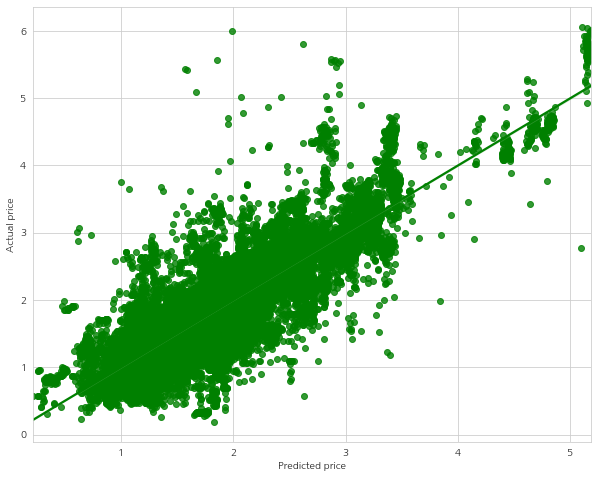

>> RMSE train = 0.41049502239287206
>> RMSE validation = 0.4173522162650154
>> MAE train = 0.29800950959278166
>> MAE validation = 0.302490425134511
-------------------------------------------------


In [154]:
model5 = train_model(df5_feature_selection.drop(columns=['P_PRICE']), df5_feature_selection['P_PRICE'])

In [164]:
columns = ['temp_kr']
for column in df5_feature_selection.columns:
    if '기타' in column:
        columns.append(column)

In [166]:
t = print_importance(model5, df5_feature_selection, columns)

CATEGORY_1_기타 : 26.785744088209587 > 0 순위
temp_kr : 1.3440032334580867 > 9 순위
CATEGORY_2_기타 : 0.3826270157656374 > 48 순위
P_NAME_기타 : 0.18198199478660743 > 88 순위
CTRY_2_기타 : 0.17571547060392306 > 90 순위
CTRY_1_기타 : 0.05414399191779573 > 114 순위
P_PURPOSE_반송품(기타) : 0.04175941628941615 > 121 순위
-------------------------------------------------
총 149 개


기타 카테고리 및 그룹핑 변수가 꽤 중요함을 확인할 수 있으나,  
모델 자체의 정확도는 감소하였다

데이터를 삭제하는 것은 언제나 위험성이 있기에,  
상관분석을 통해 변수를 추가한 부분만 최종적으로 가져간다

----

# Final DF

In [277]:
df_final = df_train.copy()

## Preprocess

In [278]:
# 컬럼 삭제
df_final = df_final.drop(columns=['P_TYPE'])

In [279]:
# 날씨
df_final = df_final.replace([np.datetime64('2017-01-01'), np.datetime64('2017-01-06')],
                            [np.datetime64('2017-01-02'), np.datetime64('2017-01-09')])

set_week(df_final, 'REG_DATE')

In [280]:
# 파생변수 추가
get_cnt(df_final, 'CTRY_1', 'ctry1_cnt')  # 제조국 수 컬럼 추가
get_cnt(df_final, 'CTRY_2', 'ctry2_cnt')  # 수출국 수 컬럼 추가
get_cnt(df_final, 'P_PURPOSE', 'purpose_cnt')  # 수입용도 수 컬럼 추가
get_cnt(df_final, 'CATEGORY_1', 'category1_cnt')
get_cnt(df_final, 'CATEGORY_2', 'category2_cnt')
get_cnt(df_final, 'P_NAME', 'name_cnt')  # 어종별 수 컬럼 추가
df_final['is_processed'] = (df_final['CTRY_1'] != df_final['CTRY_2'])  # 가공 여부 컬럼 추가

In [281]:
# 파생변수 추가
df_final['import_cnt'] = 0
for name in import_type_list:
    df_final[name] = 0
    df_final.loc[df_final['P_IMPORT_TYPE'].str.contains(name, regex=False), name] = 1    
    df_final.loc[df_final['P_IMPORT_TYPE'].str.contains(name, regex=False), 'import_cnt'] += 1

In [282]:
# 이상치 제거
df_final = df_final[df_final['P_PRICE'] < 500]

In [283]:
# 데이터 추가
df_final = merge_df([df_final, df_oil, df_weather_kr, df_cpi])

In [284]:
# 정규화
df_final['P_PRICE'] = np.log1p(df_final['P_PRICE'])
added = ['name_cnt', 'import_cnt']
for column in added:
    df_final[column] = np.log1p(df_final[column])

In [285]:
# Grouping
df_final['temp_kr'] = (df_final['temperature_kr'] + df_final['water_temp_kr']) / 2

In [286]:
# One Hot Encoding
one_hot = ['CTRY_1', 'CTRY_2', 'P_PURPOSE', 'CATEGORY_1', 'CATEGORY_2', 'P_NAME']
df_final = pd.get_dummies(df_final, columns=one_hot)

In [287]:
# Drop
df_final.drop(columns=['ctry2_cnt', 'cpi_fish', 'temperature_kr', 'water_temp_kr', 'P_IMPORT_TYPE'], axis=1, inplace=True)

## Train

Model Training Complete!


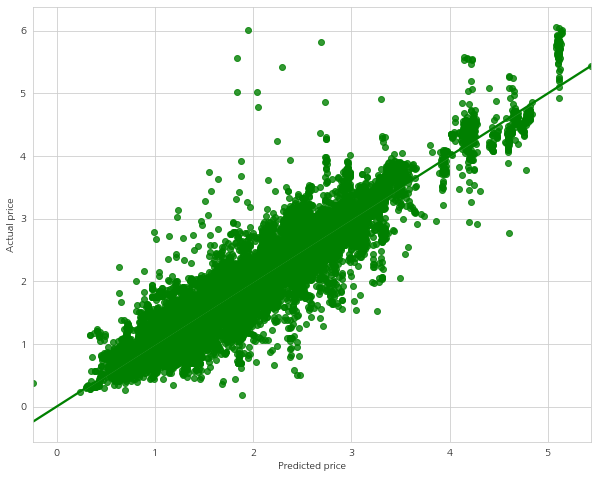

>> RMSE train = 0.26123934410790584
>> RMSE validation = 0.2714239232444337
>> MAE train = 0.17940778996832538
>> MAE validation = 0.1867711177765937
-------------------------------------------------


In [288]:
model = train_model(df_final.drop(columns=['P_PRICE']), df_final['P_PRICE'])

In [290]:
final_fs = print_importance(model, df_final, [])

-------------------------------------------------
총 636 개


## Save

In [293]:
df_final.to_csv(os.path.join(root, "preproecessed_train_2.csv"), encoding='utf-8', index=False)

### Selecting Numerical Features - RFE

In [ ]:
from sklearn.feature_selection import RFE

In [ ]:
X, y = df5_feature_selection.drop(columns=['P_PRICE'], axis=1), df5_feature_selection['P_PRICE']

#no of features
nof_list = np.arange(1, len(df5_feature_selection.columns))            
high_score = 0

#Variable to store the optimum features
nof = 0           
score_list = []
for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0)
    model = LinearRegression()
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

In [ ]:
cols = list(X.columns)
model = LinearRegression()

#Initializing RFE model
rfe = RFE(model, nof)   

#Transforming data using RFE
X_rfe = rfe.fit_transform(X,y)  

#Fitting the data to model
model.fit(X_rfe,y)              
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index

print(selected_features_rfe)

### Selecting Features - ANOVA

In [ ]:
# # ANOVA feature selection for numeric input and categorical output
# from sklearn.datasets import make_classification
# from sklearn.feature_selection import SelectKBest
# from sklearn.feature_selection import f_classif

# # generate dataset
# X, y = df5_feature_selection.drop(columns=['P_PRICE'] + categorical, axis=1), df5_feature_selection['P_PRICE']

# # define feature selection
# fs = SelectKBest(score_func=f_classif, k=12)

# # apply feature selection
# X_selected = fs.fit_transform(X, y)
# print(X_selected.shape)

### Selecting Categorical Features - mutual_info_regression

In [ ]:
# from sklearn.feature_selection import mutual_info_regression
# X, y = df5_feature_selection.drop(columns=['P_PRICE'] , axis=1), df5_feature_selection['P_PRICE']
# a = mutual_info_regression(X, y)